# INTRODUCTION

We performed an experiment with simple recommenders.  Users were invited to use a news website.  They were divided in three groups, each with a different recommender configuration.  We wonder now if there is a recommender that leads to more clicks.

In [4]:
import json

fileEvents = 'user-dump.js'

import json
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import pprint


# LOAD & TRANSFORM

Here, we load the experimental data, and tranform it into a workable format.  The code in this section is specific for this dataset, and is not important for the evaluation of the statistical methodology.
 

In [23]:
# Load events
fileEvents = 'user-dumps.json'
with open(fileEvents) as json_data:
    events = json.load(json_data)
    json_data.close()

In [55]:
# Create a dictionary: for each group: this dictionary has a list with the number of clicks per user.

clicks_groups = {'group-1':[],
                'group-2':[],
                'group-3':[]}

for e in range(len(events)):
    if 'group' in events[e].keys():
        if 'VRT' in events[e]['group'].keys():
            if events[e]['group']['VRT'] in clicks_groups.keys():
                group_ = events[e]['group']['VRT']
            
                clicks_ = 0
                if 'articles' in events[e].keys():
                    if 'VRT'in events[e]['articles']:
                        clicks_ = len(events[e]['articles']['VRT'])            
                clicks_groups[group_].append(clicks_)

# VISUAL ANALYSIS


We wonder which group has more clicks per user.

In [78]:
# Average clicks per group
clicks_groups_av = {}
for key in clicks_groups.keys():
    clicks_groups_av[key] = np.mean(clicks_groups[key])
    
clicks_groups_av

{'group-1': 7.144578313253012,
 'group-2': 5.828767123287672,
 'group-3': 4.2037617554858935}

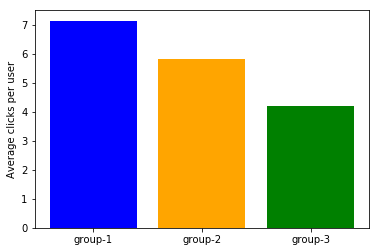

In [65]:
# Plot of average clicks per group
color = ['b','orange','g']
plt.figure()
plt.bar(clicks_groups_av.keys(), clicks_groups_av.values(), color=color)
plt.ylabel('Average clicks per user')
plt.show()

In [79]:
clicks_groups_av['group-1']-clicks_groups_av['group-2']

1.3158111899653404

We can see that group-1 has on average more clicks than group-2.  This is our observed statistic:

$$\mu_{obs} = mean(c_1) - mean(c_2) = 1.316$$

But is this difference significant?

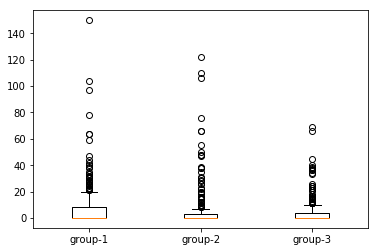

In [77]:
# Boxplot of clicks per group
plt.figure()
plt.boxplot([clicks_groups[key] for key in clicks_groups.keys()])
plt.xticks(range(1,len(clicks_groups)+1), clicks_groups.keys())
plt.show()

# BOOTSTRAP

We propose the null hypothesis that on average, group-1 does not have more clicks than group-2, i.e.

$$ \text{Null hypothesis: } \mu_{obs} <= 0 $$

We will perform a bootstrap significance test as follows.  

- We generate $n_b$ bootstrap samples: random samples for group-1 and group-2, that have the same size as the original groups.  Note that these have duplicates (resampling with replacement).

- For each bootstrap sample, we calculate the bootstrap statistic.  In this case, this is the difference between the averages of the groups:

$$\mu_i = mean(c_{1,i}) - mean(c_{2,i})$$

- We store the difference between each bootstrap statistic and the observed statistic in a list $diff$.

- The p-value is the fraction of the elements of $diff$ that is larger than $\mu_{obs}$:

$$ p = \frac{1}{n_b} \Sigma_i (diff_i > \mu_{obs}) $$


In code, this becomes the following.



In [119]:
# Null hypothesis: mean(pop1) > mean(pop2)

pop1 = clicks_groups['group-1']
pop2 = clicks_groups['group-2']
bootstrap_size = 1000


# Observed statistic
stat_obs = (np.mean(pop1) - np.mean(pop2))


# Bootstrap sampling
diff = []
for b in range(bootstrap_size):
    sample1 = np.random.choice(pop1, len(pop1))
    sample2 = np.random.choice(pop2, len(pop2))
    stat_bootstrap = (np.mean(sample1) - np.mean(sample2))
    diff.append(stat_bootstrap - stat_obs)

    
# pvalue
pvalue = np.sum(diff > stat_obs)/bootstrap_size
print(pvalue)

0.137


The exact p-value depends on the random resampling, but usually we have a p-value larger than 0.1.  This means that the difference is not significant, and that we cannot reject the null hypothesis based on this dataset.


# FURTHER TESTING

We want to do more experiments, and it would be handy to have all the details for the calculation of the p-value in a function.

In [121]:
def pvalue(pop1, pop2, bootstrap_size = 1000):
    # Null hypothesis: mean(pop1) > mean(pop2)
    
    # Observed statistic
    stat_obs = (np.mean(pop1) - np.mean(pop2))

    # Bootstrap sampling
    stat_bootstrap = []
    for b in range(bootstrap_size):
        sample1 = np.random.choice(pop1, len(pop1))
        sample2 = np.random.choice(pop2, len(pop2))
        stat_bootstrap.append((np.mean(sample1) - np.mean(sample2)) - stat_obs)

    # pvalue
    return np.sum(stat_bootstrap > stat_obs)/bootstrap_size


Let's try this function, to see if group-1 has significantly more clicks than group-3.

In [122]:
pvalue(pop1 = clicks_groups['group-1'], 
       pop2 = clicks_groups['group-3'], 
       bootstrap_size = 1000)


0.004

Yay!  There are significantly more clicks in group-1 than in group-3. 